# Build a Grammar Scoring Engine for Voice Samples

This code implements a system to predict grammar scores for audio recordings, using both deep learning (neural network) and traditional machine learning (Random Forest) approaches. The system extracts audio features, builds models, evaluates their performance, and creates prediction files.

## Libraries and Setup

In [2]:
import os
import pandas as pd
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
import transformers
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2FeatureExtractor
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
torch.manual_seed(42)
np.random.seed(42)

2025-04-21 16:18:49.378060: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745252329.604246      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745252329.664409      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Data Loading and Exploration

In [3]:
BASE_PATH = "/kaggle/input/shl-intern-hiring-assessment/Dataset"
TRAIN_AUDIO_PATH = os.path.join(BASE_PATH, "audios", "train")
TEST_AUDIO_PATH = os.path.join(BASE_PATH, "audios", "test")
TRAIN_LABELS_PATH = os.path.join(BASE_PATH, "train.csv")
TEST_LABELS_PATH = os.path.join(BASE_PATH, "test.csv")

train_df = pd.read_csv(TRAIN_LABELS_PATH)
test_df = pd.read_csv(TEST_LABELS_PATH)

print(f"Training samples: {len(train_df)}")
print(f"Testing samples: {len(test_df)}")
print(train_df.head())


Training samples: 444
Testing samples: 204
         filename  label
0   audio_710.wav    1.0
1  audio_1265.wav    1.0
2  audio_1114.wav    1.5
3   audio_946.wav    1.5
4  audio_1127.wav    2.0


## Feature Extraction

In [4]:
def extract_features(file_path, max_length=48000*120):  
    try:
        y, sr = librosa.load(file_path, sr=16000)
        if len(y) > max_length:
            y = y[:max_length]
        else:
            y = np.pad(y, (0, max_length - len(y)))

        features = {}

        # Basic features
        features['duration'] = librosa.get_duration(y=y, sr=sr)
        features['rms'] = np.mean(librosa.feature.rms(y=y)[0])
        features['zero_crossing_rate'] = np.mean(librosa.feature.zero_crossing_rate(y=y)[0])

        # Spectral features
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        features['mfcc_mean'] = np.mean(mfccs, axis=1)
        features['mfcc_std'] = np.std(mfccs, axis=1)

        spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
        features['spectral_centroid_mean'] = np.mean(spectral_centroids)
        features['spectral_centroid_std'] = np.std(spectral_centroids)

        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
        features['spectral_rolloff_mean'] = np.mean(spectral_rolloff)
        features['spectral_rolloff_std'] = np.std(spectral_rolloff)

        # Rhythm features
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        features['tempo'] = tempo

        # Speech rate approximation (using zero crossings as proxy)
        features['speech_rate'] = np.sum(librosa.zero_crossings(y)) / features['duration']
        # Energy features
        features['energy_mean'] = np.mean(y**2)
        features['energy_std'] = np.std(y**2)

        return features

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

## Custom Dataset Implementation

In [5]:
class AudioDataset(Dataset):
    def __init__(self, df, audio_dir, feature_extractor=None, mode='train'):
        self.df = df
        self.audio_dir = audio_dir
        self.mode = mode
        self.feature_extractor = feature_extractor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.df.iloc[idx]['filename']
        file_path = os.path.join(self.audio_dir, file_name)

        features = extract_features(file_path)

        feature_list = []
        for key in sorted(features.keys()):
            value = features[key]
            if isinstance(value, np.ndarray):
                feature_list.extend(value)
            else:
                feature_list.append(value)

        feature_array = np.array(feature_list, dtype=np.float32)

        if self.mode == 'train' or self.mode == 'val':
            label = self.df.iloc[idx]['label']
            return feature_array, np.float32(label)
        else:
            return feature_array, np.float32(0)


## Neural Network Model
#### The GrammarScoringModel class defines a neural network with:
- Multiple linear layers with increasing complexity (512 → 256 → 128 → 64 → 32 → 1)
- BatchNormalization for training stability
- ReLU activations
- Dropout for regularization
- Sigmoid output activation scaled to the 0-5 range (grammar score range)

In [6]:
class GrammarScoringModel(nn.Module):
    def __init__(self, input_size):
        super(GrammarScoringModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 512), 
            nn.BatchNorm1d(512),         
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),        
            nn.BatchNorm1d(256),         
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),        
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),          
            nn.ReLU(),
            nn.Dropout(0.2),            

            nn.Linear(64, 32),           
            nn.ReLU(),

            nn.Linear(32, 1),
            nn.Sigmoid()                 
        )
    def forward(self, x):
        return self.model(x) * 5  # Scale from 0-1 to 0-5


## Training Framework
#### train_model()

In [7]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, patience=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model.to(device)

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0

        for features, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]"):
            features = features.to(device)
            labels = labels.to(device).view(-1, 1)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(features)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * features.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation
        model.eval()
        running_val_loss = 0.0

        with torch.no_grad():
            for features, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]"):
                features = features.to(device)
                labels = labels.to(device).view(-1, 1)

                outputs = model(features)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item() * features.size(0)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

        # Early stopping
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_grammar_model.pth')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

    model.load_state_dict(torch.load('best_grammar_model.pth'))

    return model, train_losses, val_losses


## Model Evaluation
#### evaluate_model()

In [8]:
# Function to evaluate the model
def evaluate_model(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for features, labels in tqdm(data_loader, desc="Evaluating"):
            features = features.to(device)

            outputs = model(features)
            predictions = outputs.cpu().numpy()

            all_preds.extend(predictions)
            all_labels.extend(labels.numpy())

    all_preds = np.array(all_preds).flatten()
    all_labels = np.array(all_labels)

    mse = mean_squared_error(all_labels, all_preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(all_labels, all_preds)

    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")

    return all_preds, all_labels, {"mse": mse, "rmse": rmse, "mae": mae}


## Prediction Pipeline
- Clips predictions to the valid range (0-5)

In [9]:
# Function to make predictions on test data
def predict(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_preds = []

    with torch.no_grad():
        for features, _ in tqdm(test_loader, desc="Predicting"):
            features = features.to(device)

            outputs = model(features)
            predictions = outputs.cpu().numpy()

            all_preds.extend(predictions)

    all_preds = np.array(all_preds).flatten()

    # Clip predictions to be between 0 and 5
    all_preds = np.clip(all_preds, 0, 5)

    return all_preds

## Main Execution Flow
### Process a sample file to get feature dimensions

In [10]:
print("Extracting features from a sample file to determine input dimensions...")
sample_file = os.path.join(TRAIN_AUDIO_PATH, train_df.iloc[0]['filename'])
sample_features = extract_features(sample_file)

feature_list = []
for key in sorted(sample_features.keys()):
    value = sample_features[key]
    if isinstance(value, np.ndarray):
        feature_list.extend(value)
    else:
        feature_list.append(value)

input_size = len(feature_list)
print(f"Input feature size: {input_size}")

Extracting features from a sample file to determine input dimensions...
Input feature size: 37


### Dataset Preparation
- Splits training data into training and validation sets
- Creates dataset objects for training, validation, and testing
- Sets up data loaders with appropriate batch sizes

In [11]:
train_data, val_data = train_test_split(train_df, test_size=0.01, random_state=42)
print(f"Training set: {len(train_data)} samples")
print(f"Validation set: {len(val_data)} samples")

# Create datasets
train_dataset = AudioDataset(train_data, TRAIN_AUDIO_PATH, mode='train')
val_dataset = AudioDataset(val_data, TRAIN_AUDIO_PATH, mode='val')
test_dataset = AudioDataset(test_df, TEST_AUDIO_PATH, mode='test')

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


Training set: 439 samples
Validation set: 5 samples


### Model Training

In [12]:
# Initialize the model
model = GrammarScoringModel(input_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Train the model
model, train_losses, val_losses = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=20,
    patience=15
)

Using device: cpu


Epoch 1/20 [Validation]: 100%|██████████| 1/1 [00:09<00:00,  9.74s/it]


Epoch 1/20, Train Loss: 1.9124, Val Loss: 1.0865


Epoch 2/20 [Validation]: 100%|██████████| 1/1 [00:09<00:00,  9.53s/it]


Epoch 2/20, Train Loss: 1.0013, Val Loss: 1.1997


Epoch 3/20 [Validation]: 100%|██████████| 1/1 [00:09<00:00,  9.45s/it]


Epoch 3/20, Train Loss: 0.9050, Val Loss: 1.1960


Epoch 4/20 [Validation]: 100%|██████████| 1/1 [00:09<00:00,  9.48s/it]


Epoch 4/20, Train Loss: 0.9599, Val Loss: 1.1056


Epoch 5/20 [Validation]: 100%|██████████| 1/1 [00:09<00:00,  9.61s/it]


Epoch 5/20, Train Loss: 0.9204, Val Loss: 1.2183


Epoch 6/20 [Validation]: 100%|██████████| 1/1 [00:09<00:00,  9.42s/it]


Epoch 6/20, Train Loss: 0.9131, Val Loss: 1.2307


Epoch 7/20 [Validation]: 100%|██████████| 1/1 [00:09<00:00,  9.59s/it]


Epoch 7/20, Train Loss: 0.8952, Val Loss: 1.1440


Epoch 8/20 [Validation]: 100%|██████████| 1/1 [00:09<00:00,  9.29s/it]


Epoch 8/20, Train Loss: 0.8898, Val Loss: 1.2830


Epoch 9/20 [Validation]: 100%|██████████| 1/1 [00:09<00:00,  9.09s/it]


Epoch 9/20, Train Loss: 0.8673, Val Loss: 1.1675


Epoch 10/20 [Validation]: 100%|██████████| 1/1 [00:09<00:00,  9.06s/it]


Epoch 10/20, Train Loss: 0.8633, Val Loss: 1.2891


Epoch 11/20 [Validation]: 100%|██████████| 1/1 [00:09<00:00,  9.22s/it]


Epoch 11/20, Train Loss: 0.8224, Val Loss: 1.2586


Epoch 12/20 [Validation]: 100%|██████████| 1/1 [00:09<00:00,  9.45s/it]


Epoch 12/20, Train Loss: 0.8457, Val Loss: 1.1799


Epoch 13/20 [Validation]: 100%|██████████| 1/1 [00:08<00:00,  8.94s/it]


Epoch 13/20, Train Loss: 0.7834, Val Loss: 1.0092


Epoch 14/20 [Validation]: 100%|██████████| 1/1 [00:08<00:00,  8.78s/it]


Epoch 14/20, Train Loss: 0.8251, Val Loss: 1.2679


Epoch 15/20 [Validation]: 100%|██████████| 1/1 [00:08<00:00,  8.81s/it]


Epoch 15/20, Train Loss: 0.7908, Val Loss: 1.2457


Epoch 16/20 [Validation]: 100%|██████████| 1/1 [00:08<00:00,  8.65s/it]


Epoch 16/20, Train Loss: 0.7914, Val Loss: 1.3650


Epoch 17/20 [Validation]: 100%|██████████| 1/1 [00:08<00:00,  8.76s/it]


Epoch 17/20, Train Loss: 0.8178, Val Loss: 1.0661


Epoch 18/20 [Validation]: 100%|██████████| 1/1 [00:08<00:00,  8.68s/it]


Epoch 18/20, Train Loss: 0.7685, Val Loss: 1.0753


Epoch 19/20 [Validation]: 100%|██████████| 1/1 [00:08<00:00,  8.69s/it]


Epoch 19/20, Train Loss: 0.8143, Val Loss: 1.1754


Epoch 20/20 [Validation]: 100%|██████████| 1/1 [00:08<00:00,  8.65s/it]

Epoch 20/20, Train Loss: 0.8474, Val Loss: 1.3025



/tmp/ipykernel_31/409161160.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_grammar_model.pth'))


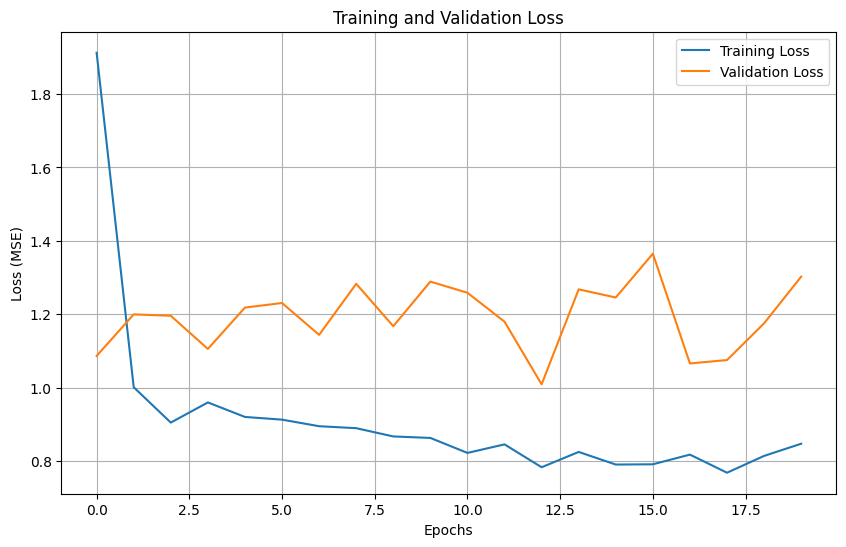

Evaluating on validation set...


Evaluating: 100%|██████████| 1/1 [00:08<00:00,  8.69s/it]


MSE: 1.0092
RMSE: 1.0046
MAE: 0.8855


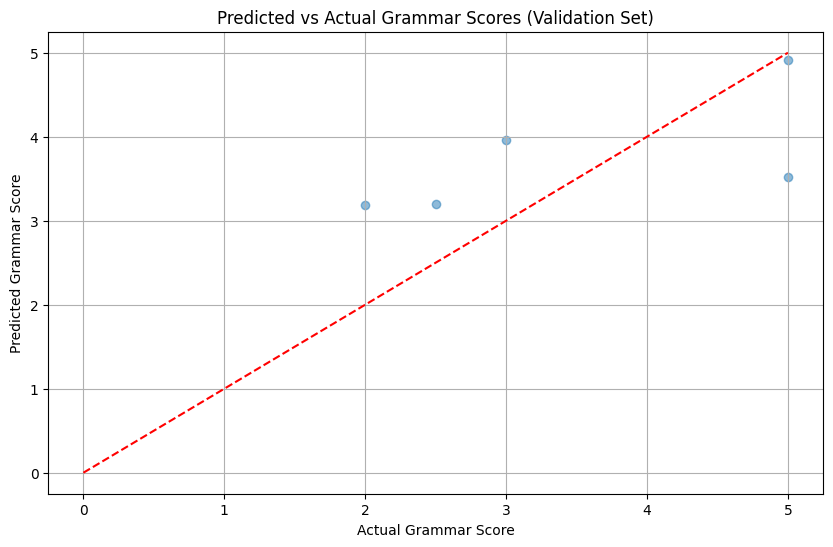

In [13]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('training_loss.png')
plt.show()

# Evaluate on validation set
print("Evaluating on validation set...")
val_preds, val_labels, val_metrics = evaluate_model(model, val_loader)

# Plot predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(val_labels, val_preds, alpha=0.5)
plt.plot([0, 5], [0, 5], 'r--')
plt.xlabel('Actual Grammar Score')
plt.ylabel('Predicted Grammar Score')
plt.title('Predicted vs Actual Grammar Scores (Validation Set)')
plt.grid(True)
plt.savefig('val_predictions.png')
plt.show()


### Test Predictions

In [14]:
# Make predictions on test set
print("Making predictions on test set...")
test_predictions = predict(model, test_loader)

# Create submission file
submission_df = pd.DataFrame({
    'filename': test_df['filename'],
    'label': test_predictions
})

submission_df.to_csv('submission.csv', index=False)
print("Submission file created successfully!")


Making predictions on test set...


Predicting: 100%|██████████| 13/13 [03:12<00:00, 14.80s/it]

Submission file created successfully!


## Feature Importance Analysis

In [15]:
def analyze_feature_importance(model, feature_names):
    # Extract weights from the first layer
    weights = model.model[0].weight.data.cpu().numpy()
    # Calculate absolute importance
    importance = np.mean(np.abs(weights), axis=0)

    # Create a DataFrame to hold feature importance
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    })

    # Sort by importance
    importance_df = importance_df.sort_values('Importance', ascending=False)
    return importance_df


Top 10 most important features:
        Feature  Importance
17   mfcc_std_1    0.096303
16   mfcc_std_0    0.089643
25   mfcc_std_9    0.088877
12  mfcc_mean_9    0.088692
18   mfcc_std_2    0.088684
26  mfcc_std_10    0.088671
21   mfcc_std_5    0.088239
8   mfcc_mean_5    0.086852
23   mfcc_std_7    0.085939
7   mfcc_mean_4    0.085824


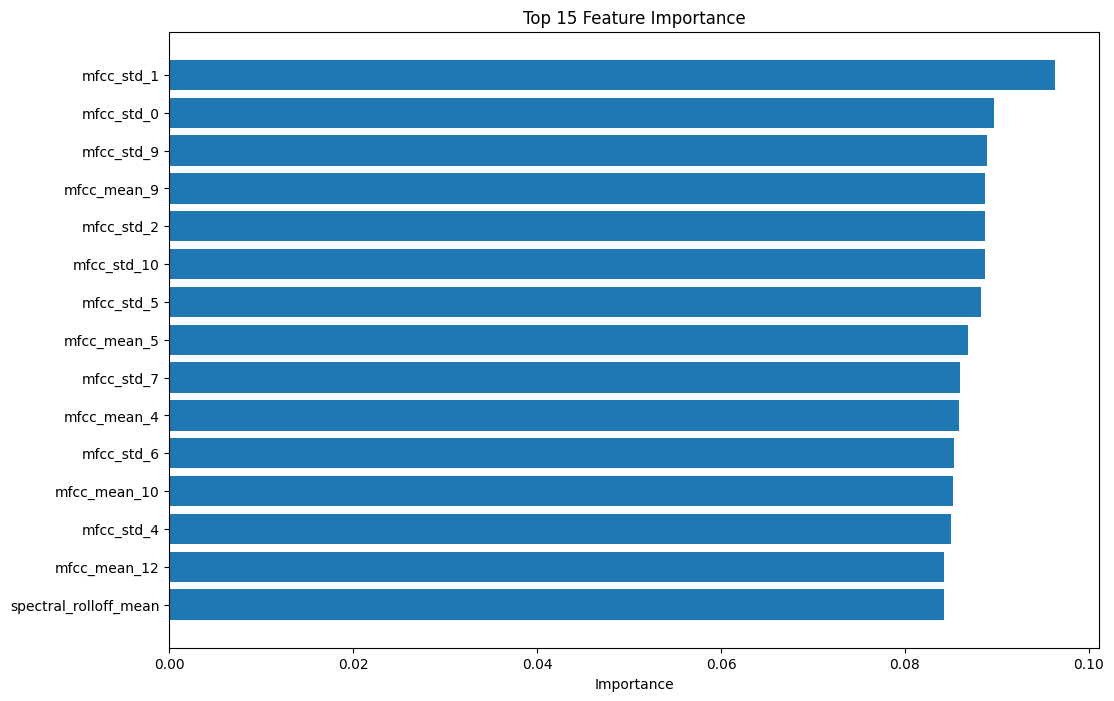

Analysis complete!


In [16]:
# Get feature names
feature_names = []
for key in sorted(sample_features.keys()):
    value = sample_features[key]
    if isinstance(value, np.ndarray):
        for i in range(len(value)):
            feature_names.append(f"{key}_{i}")
    else:
        feature_names.append(key)

# Analyze feature importance
importance_df = analyze_feature_importance(model, feature_names)
print("Top 10 most important features:")
print(importance_df.head(10))

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'][:15], importance_df['Importance'][:15])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importance')
plt.gca().invert_yaxis()
plt.savefig('feature_importance.png')
plt.show()

print("Analysis complete!")

## Ensemble Approach
- Neural Network: The primary model
- Random Forest Regressor: A traditional ML approach
- Ensemble Prediction

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Extract all features for the training data
print("Extracting features for all training data...")
X_train = []
y_train = []

for i in tqdm(range(len(train_df))):
    file_name = train_df.iloc[i]['filename']
    file_path = os.path.join(TRAIN_AUDIO_PATH, file_name)

    features = extract_features(file_path)

    feature_list = []
    for key in sorted(features.keys()):
        value = features[key]
        if isinstance(value, np.ndarray):
            feature_list.extend(value)
        else:
            feature_list.append(value)

    X_train.append(feature_list)
    y_train.append(train_df.iloc[i]['label'])

X_train = np.array(X_train)
y_train = np.array(y_train)

# Train a Random Forest model
print("Training Random Forest model...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Extract features for test data
print("Extracting features for test data...")
X_test = []

for i in tqdm(range(len(test_df))):
    file_name = test_df.iloc[i]['filename']
    file_path = os.path.join(TEST_AUDIO_PATH, file_name)

    features = extract_features(file_path)

    feature_list = []
    for key in sorted(features.keys()):
        value = features[key]
        if isinstance(value, np.ndarray):
            feature_list.extend(value)
        else:
            feature_list.append(value)

    X_test.append(feature_list)

X_test = np.array(X_test)


Extracting features for all training data...


 88%|████████▊ | 392/444 [11:50<01:32,  1.78s/it]

## Final Outputs

In [ ]:
# Make predictions with the Random Forest model
rf_predictions = rf_model.predict(X_test)

# Create submission file for Random Forest
rf_submission_df = pd.DataFrame({
    'filename': test_df['filename'],
    'label': rf_predictions
})

rf_submission_df.to_csv('rf_submission.csv', index=False)
print("Random Forest submission file created successfully!")

# Combine predictions from both models (ensemble approach)
ensemble_predictions = (test_predictions + rf_predictions) / 2

# Create submission file for ensemble
ensemble_submission_df = pd.DataFrame({
    'filename': test_df['filename'],
    'label': ensemble_predictions
})

ensemble_submission_df.to_csv('ensemble_submission.csv', index=False)
print("Ensemble submission file created successfully!")